In [12]:
import numpy as np
np.random.seed(123)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from changepoynt.algorithms.sst import SST
from changepoynt.visualization.score_plotting import plot_data_and_score

In [2]:
# make synthetic step function
x0 = 1 * np.ones(500) + np.random.rand(500) * 1
x1 = 3 * np.ones(500) + np.random.rand(500) * 2
x2 = 5 * np.ones(500) + np.random.rand(500) * 1.5
x = np.hstack([x0, x1, x2])
x += np.random.rand(x.size)

In [3]:
# measure the timings and also plot them
def time_per_window_length(window_length: int, method: str, fast_hankel: bool):

    # create the SST object
    sst = SST(window_length, method=method, use_fast_hankel=fast_hankel)

    # compute the scores and add to the timing
    start = time.perf_counter()
    sst.transform(x)
    measured_time = time.perf_counter()-start
    return measured_time

def measure_time():
    # measure the two methods for different timings
    win_lengths_candidates = np.logspace(1.47712125472,2.602,5).astype(int) # 30 to 400

    # trigger the jit compilation so comparison is fair
    SST(30, method='ika').transform(x)
    SST(30, method='ika', use_fast_hankel=True).transform(x)
    SST(30, method='rsvd').transform(x)
    SST(30, method='rsvd', use_fast_hankel=True).transform(x)
    SST(30, method='naive').transform(x)

    methods = []
    measured_times = []
    window_lengths = []

    for method in ("naive", "ika", "rsvd"):
        for wl in win_lengths_candidates:
            for use_fast_hankel in (True, False):
                if method == "naive" and use_fast_hankel:
                    continue
                for j in range(5):
                    measured_times.append(time_per_window_length(wl, method=method, fast_hankel=use_fast_hankel))
                    methods.append(f"{method}_{'fastHankel' if use_fast_hankel else 'normal'}")
                    window_lengths.append(wl)

    return pd.DataFrame({"time[s]": measured_times, "method":methods, "window length":window_lengths})

In [4]:
df = measure_time()  # takes about 15-20min!

In the next cell we will plot the time measurement results. This is just an example, for details refer to our (hopefully soon) published paper.

You can see the following from the results:
- Naive SST scales really bad
- The ika with fast hankel product is pretty fast and scales really well for large window sizes N (N*logN instead of N² or even N³)
- There is a constant offset for using the fast hankel product, which is why the normal product is faster for lower window sizes
- For the rsvd method the scaling only really takes effect for relatively large window sizes

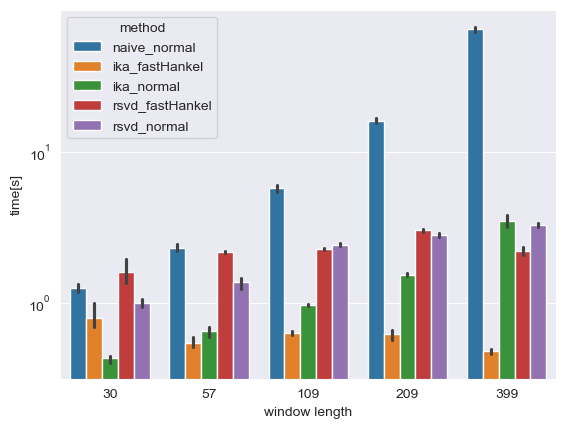

In [13]:
# plot the results
sns.barplot(x="window length", y="time[s]", hue="method", data=df)
plt.yscale("log")